# Agent example in LangChain

## Installation

In [ ]:
!pip install langchain_google_vertexai langraph

Let's explore how to build an agent using LangChain with a practical example. Our goal is to create an agent capable of managing a user's bank accounts. This agent should be able to retrieve the balance of each account and execute transactions between them.

While in a production environment we would interact with dedicated banking systems via APIs, let's craft a simple mock framework for our example.

In [20]:
from pydantic import BaseModel


class Account(BaseModel):
    """Represents a bank account with a name and balance."""
    name: str
    balance: float

class UserAccounts(BaseModel):
    """Represents a collection of bank accounts for a user."""

    accounts: list[Account]

    def get_account_names(self) -> list[str]:
        """Returns a list of the names of all accounts."""
        return [account.name for account in self.accounts]

    def get_account(self, account_name: str) -> Account:
        """Returns the account with the given name.

        Raises:
            ValueError: If no account with the given name exists.
        """
        for account in self.accounts:
            if account_name == account.name:
                return account
        error_message = (
            f"There is no account named {account_name}. "
            f"Options are {', '.join(self.get_account_names())}"
        )
        raise ValueError(error_message)
    
    def transfer_money(self, amount: float, source_acc_name: str, dest_acc_name: str) -> None:
        """Transfers money from one account to another.

        Raises:
            ValueError: If the source account does not have enough funds.
        """
        source_account = self.get_account(source_acc_name)
        destination_account = self.get_account(dest_acc_name)
        
        if source_account.balance < amount:
            error_message = (
                f"There is not enough funds in account {source_acc_name}. "
                f"The balance is only ${source_account.balance}."
            )
            raise ValueError(error_message)
        
        source_account.balance = source_account.balance - amount
        destination_account.balance = destination_account.balance + amount

This implementation exposes three methods:

`get_account_names`: This method returns a list of the names of the accounts associated with the user.

`get_account`: This method retrieves a specific account by its name. If the account doesn't exist, it raises a `ValueError` with a clear message indicating the issue and available account options.

`transfer_money`: This method allows transferring funds between accounts. It takes the amount, source account name, and destination account name as arguments. It includes error handling to ensure sufficient funds in the source account before executing the transfer.

Let's use this implementation to define the tools for the agent.

### Tools

To define the tools available to our agent effectively, we'll employ a decorator and create a global `UserAccounts` object holding user account information as a practical example. As discussed in the preceding chapter, comprehensive docstrings are essential, providing the LLM with the context necessary to determine the appropriate tool to call in any given situation.

In [2]:
from langchain_core.tools import tool

USER_ACCOUNTS = UserAccounts(
    accounts=[
        Account(name="checking-account", balance=100),
        Account(name="savings-account", balance=3_000)
    ]
)

@tool
def list_accounts() -> str:
    """List the names of the user's accounts."""
    return USER_ACCOUNTS.get_account_names()

@tool
def get_account_balance(account_name: str) -> str:
    """Get the balance of one of the user accounts by its exact name.""" 
    try:
        account = USER_ACCOUNTS.get_account(account_name)
        return f"${account.balance}"
    except ValueError as error:
        return f"{error}"


@tool
def transfer_money(amount: float, source_account: str, destination_account: str) -> str:
    """Transfer money between two accounts."""
    try:
        USER_ACCOUNTS.transfer_money(amount, source_account, destination_account)
        return "Successful transaction"
    except ValueError as error:
        return f"{error}"

tools = [
    list_accounts, 
    get_account_balance,
    transfer_money
]

Having defined our toolkit, we will next specify the model responsible for orchestrating their use. This model will  select the most suitable tool for each interaction and generate contextually relevant responses.

### Model

For that, we instantiate a `ChatVertexAI` object, which provides an interface to the Gemini 1.5 Pro model. We set the temperature parameter to 0 to encourage the model to produce more focused and consistent responses, which is generally beneficial when working with agents that rely on function calling. Remember that you can further customize this instantiation with additional parameters to fine-tune the model's behavior according to your specific requirements such as the safety settings or the maximum number of output tokens.

In [3]:
from langchain_google_vertexai import ChatVertexAI

MODEL_NAME = "gemini-1.5-pro-002"

model = ChatVertexAI(
  model_name=MODEL_NAME, 
  temperature = 0
)

Let's now try to refine the behaviour of the model by creating a prompt for it.

### Prompt template

Now, let's refine the model's behavior by designing an effective prompt. We'll utilize the ChatPromptTemplate class for this purpose. This class requires two components:

- `SystemPromptTemplate`: This component contains the general instructions for the model, guiding its overall behavior. For this particular example a `SystetPrompt` would be enough because we don't have any template parameters, but is a good idea to have it in place in case we want to include some later on.
  
- `MessagesPlaceholder`: This component includes a list of messages, encompassing both the conversation history and the user's current query.
  
Let's examine the code snippet below to see how this can be implemented:

In [4]:
from langchain_core.prompts import (
  ChatPromptTemplate, 
  MessagesPlaceholder, 
  SystemMessagePromptTemplate, 
)

prompt_template = ChatPromptTemplate.from_messages([
  SystemMessagePromptTemplate.from_template(
    """
    You are an agent that helps the user manage their accounts in a Bank.
    
    Users may not refer to their account by the exact name, so try to get a list of valid names
    before getting a balance or executing a transaction.
    """
  ),
  MessagesPlaceholder(
    variable_name="messages", 
    optional=True
  )
])


The core of this system prompt lies in the message provided within the `SystemMessagePromptTemplate`. 

This message instructs the language model to assume the role of a banking agent. It explicitly tells the model to prioritize identifying the correct account names before proceeding with any balance inquiries or transactions. This is very important because users might use colloquial or imprecise names to refer to their accounts.

Now that we have all components of the agent built, let's create the actual object.

## Agent creation

To create the agent, we'll use the `langgraph` library introduced in the previous chapter. The `langgraph.prebuilt` module provides the create_react_agent function, which simplifies building the agent architecture. In the next chapter, we'll explore how to build cognitive architectures from scratch.

In [5]:
from langgraph.prebuilt import create_react_agent
 
agent = create_react_agent(
    model=model, 
    tools=tools, 
    state_modifier=prompt_template
)

Note that the prompt is included using the `state_modifier` parameter. Besides a prompt template, this argument can be any `Runnable` that can be chained to the model and takes the state as an input.

The graph created by this function looks like the following figure:

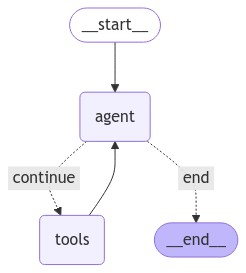

In [30]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

Upon receiving input, the agent evaluates whether to generate a response directly or employ a tool. If a tool is deemed necessary, a loop is initiated. The output from the tool is then fed back into the model, prompting a reevaluation of the situation. This iterative process allows the agent to call any number of tools, as many times as required, before formulating a final response.

Let's now use the agent we just created in different scenarios.

## Agent usage

LangGraph primarily uses the `invoke` method to execute a graph. This method requires an initial state object containing a `"messages"` key. This key holds the conversation history between the user and the agent, encompassing human and agent messages, along with any intermediate tool calls and their corresponding responses. The `invoke` method processes this information, runs it through the grapht, and returns an updated state object, which includes any newly generated messages appended to the conversation history.

Let's try it with the code snippet below:

In [6]:
state = {
    "messages": [
        ("human", "Hello, what can you help me with?")
    ]
}

new_state = agent.invoke(state)

for message in new_state["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hello, what can you help me with?
================================== Ai Message ==================================

I can help you check your account balances and transfer money between your accounts.


Here we have asked a simple question to the agent, so no function calls are present in its response and it has just generated it without using any tools.

Let's ask a specific question where we now the agent must utilize one of the provided tools such as asking an account balance.

In [7]:
state = {
    "messages": [
        ("human", "Whats the balance in my savings account?")
    ]
}

agent.invoke(state)

{'messages': [HumanMessage(content='Whats the balance in my savings account?', id='da34c3bf-1e7e-4bf8-b7e8-4cf81f3a5361'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'list_accounts', 'arguments': '{}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 124, 'candidates_token_count': 3, 'total_token_count': 127}, 'finish_reason': 'STOP'}, id='run-0b0f8f39-8aaf-4159-92ee-02e083b03ecf-0', tool_calls=[{'name': 'list_accounts', 'args': {}, 'id': 'f729594c-5479-4828-80c1-462d8639b40c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 124, 'output_tokens': 3, 'total_tokens': 127}),
  ToolMessage(content='["checking-account", "savings-account"]', name='list_accounts', id='10c80591-a796-4bd6-9205-d5ba5ffe8b11', tool_call_id='f729594c-5479-4828-80c1-462d8639b40c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_account_balance', 'arguments': '{"account_name": "savings-account"}'}}, re

As we can see in the output the agent has now made to function calls:

Make a succesful transaction

In [8]:
state = {
    "messages": [
        ("human", "Transfer 10$ from checking to savings please")
    ]
}

agent.invoke(state)

{'messages': [HumanMessage(content='Transfer 10$ from checking to savings please', id='f5b02a7d-ce1e-4aa3-98d9-161b9a68bc4a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'list_accounts', 'arguments': '{}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 126, 'candidates_token_count': 3, 'total_token_count': 129}, 'finish_reason': 'STOP'}, id='run-cbeda685-8380-4072-886c-444871d8e2cf-0', tool_calls=[{'name': 'list_accounts', 'args': {}, 'id': 'b3aa4903-7f14-43d7-9a1b-209498fed3a9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 126, 'output_tokens': 3, 'total_tokens': 129}),
  ToolMessage(content='["checking-account", "savings-account"]', name='list_accounts', id='a44680ab-7168-494b-8c8d-7a71bd8236e0', tool_call_id='b3aa4903-7f14-43d7-9a1b-209498fed3a9'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_money', 'arguments': '{"destination_account": "savings-account", 

Make an impossible transaction

In [9]:
state = {
    "messages": [
        ("human", "Transfer 1,000$ from checking to savings please")
    ]
}

agent.invoke(state)

{'messages': [HumanMessage(content='Transfer 1,000$ from checking to savings please', id='0f592736-d5dc-4624-9f60-f565c9c26560'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'list_accounts', 'arguments': '{}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [], 'usage_metadata': {'prompt_token_count': 129, 'candidates_token_count': 3, 'total_token_count': 132}, 'finish_reason': 'STOP'}, id='run-5d7457f4-819f-457a-8736-f4d2935c2813-0', tool_calls=[{'name': 'list_accounts', 'args': {}, 'id': 'b63c432a-4acf-49aa-ae07-8bd75e319cae', 'type': 'tool_call'}], usage_metadata={'input_tokens': 129, 'output_tokens': 3, 'total_tokens': 132}),
  ToolMessage(content='["checking-account", "savings-account"]', name='list_accounts', id='13f1766a-8093-441a-b1f5-87ea6b5f26a6', tool_call_id='b63c432a-4acf-49aa-ae07-8bd75e319cae'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_money', 'arguments': '{"destination_account": "savings-account

More complex request

In [10]:
state = {
    "messages": [
        ("human", 
            (
            "If my checking account have more than $50, transfer 30$ from checking to savings please." 
             "Then tell me start and the final balance in both accounts."
            )
        )
    ]
}

new_state = agent.invoke(state)
for message in new_state["messages"]:
    message.pretty_print()

================================ Human Message =================================

If my checking account have more than $50, transfer 30$ from checking to savings please.Then tell me start and the final balance in both accounts.
================================== Ai Message ==================================
Tool Calls:
  list_accounts (07e23126-8f89-4936-869b-7246f9bf9625)
 Call ID: 07e23126-8f89-4936-869b-7246f9bf9625
  Args:
================================= Tool Message =================================
Name: list_accounts

["checking-account", "savings-account"]
================================== Ai Message ==================================
Tool Calls:
  get_account_balance (630a6e29-d4d7-4e11-8618-318bfe9b0317)
 Call ID: 630a6e29-d4d7-4e11-8618-318bfe9b0317
  Args:
    account_name: checking-account
================================= Tool Message =================================
Name: get_account_balance

$90.0
================================== Ai Message ======================

In [11]:
state = {
    "messages": [
        ("human", "If I have more than 100$ in my checking account, please transfer half of it to savings")
    ]
}

new_state = agent.invoke(state)
for message in new_state["messages"]:
    message.pretty_print()

================================ Human Message =================================

If I have more than 100$ in my checking account, please transfer half of it to savings
================================== Ai Message ==================================
Tool Calls:
  list_accounts (f0422086-ee17-43e4-b2ed-4fbbed1923ac)
 Call ID: f0422086-ee17-43e4-b2ed-4fbbed1923ac
  Args:
================================= Tool Message =================================
Name: list_accounts

["checking-account", "savings-account"]
================================== Ai Message ==================================
Tool Calls:
  get_account_balance (b05a12fa-1687-46e9-a0c2-348120f97c2b)
 Call ID: b05a12fa-1687-46e9-a0c2-348120f97c2b
  Args:
    account_name: checking-account
================================= Tool Message =================================
Name: get_account_balance

$60.0
================================== Ai Message ==================================

You only have $60.0 in your checking account, 

### Deploying an Agent in Reasoning Engine

In [30]:
!pip install cloudpickle


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import vertexai
from vertexai.preview import reasoning_engines


PROJECT_ID = "your-project-id"
LOCATION = "us-central1"
STAGING_BUCKET = "gs://your-staging-bucket-name"


vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)

In [23]:
class AgentApp:
    """Represents an application that can be deployed in Reasoning Engine"""
    def __init__(self, project_id: str, location: str) -> None:
        """initializes the agent"""
        self.project_id = project_id
        self.location = location


    def set_up(self):
        """Set ups the agent."""
        self._agent = agent
                

    def query(self, message: str) -> str:
        """Query the agent"""
        state = {"messages": [("human", message)]}
        new_state = self._agent.invoke(state)
        return new_state["messages"][-1].content

In [24]:
app = AgentApp(project_id=PROJECT_ID, location=LOCATION)
app.set_up()
app.query("What is my savings balance?")

'Your savings account balance is $3040.0.\n'

In [26]:
# This code won't work when running in jupyter

remote_agent = None

try:
    remote_agent = reasoning_engines.ReasoningEngine.create(
        AgentApp(project_id=PROJECT_ID, location=LOCATION),
        requirements=[
            "google-cloud-aiplatform[langchain,reasoningengine]",
            "cloudpickle==3.0.0",
            "pydantic==2.7.4",
            "langgraph",
            "httpx",
        ],
        display_name="Banking account Agent",
        description="This is an agent that helps you managing your accounts",
        extra_packages=[],
    )
except Exception as error:
    print(
        f"Error ({error})\n" 
        f"This code won't work from IPython, check: https://github.com/pydantic/pydantic/issues/9698"
    )
    

Error (403 GET https://storage.googleapis.com/storage/v1/b/your-staging-bucket-name?projection=noAcl&prettyPrint=false: jzaldivar@google.com does not have storage.buckets.get access to the Google Cloud Storage bucket. Permission 'storage.buckets.get' denied on resource (or it may not exist).)
This code won't work from IPython, check: https://github.com/pydantic/pydantic/issues/9698


In [27]:
if remote_agent:
    remote_agent.query(message="What's the balance on my savings account?")

In [28]:
if remote_agent:
    remote_agent.delete()

In [ ]:
https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/reasoning-engine/tutorial_langgraph.ipynb

# API as a tool in Agent Builder

In [ ]:
from fastapi import FastAPI

app = FastAPI()

@app.get("/list_accounts")
def list_accounts() -> str:
    """List the names of the user's accounts."""
    return USER_ACCOUNTS.get_account_names()


@app.get("/get_account_balance")
def get_account_balance(account_name: str) -> str:
    """Get the balance of one of the user accounts by its exact name.""" 
    try:
        account = USER_ACCOUNTS.get_account(account_name)
        return f"${account.balance}"
    except ValueError as error:
        return f"{error}"


@app.get("/transfer_money")
def transfer_money(amount: float, source_account: str, destination_account: str) -> str:
    """Transfer money between two accounts."""
    try:
        USER_ACCOUNTS.transfer_money(amount, source_account, destination_account)
        return "Successful transaction"
    except ValueError as error:
        return f"{error}"